## Python statistics essential training - 05_04_crossvalidation

Standard imports

In [1]:
import math

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib
import matplotlib.pyplot as pp

In [4]:
%matplotlib inline

In [5]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

Loading gapminder data for year 1985 (Live Aid!).

In [19]:
gapminder = pd.read_csv('gapminder.csv')

In [20]:
gdata = gapminder.query('year == 1985')

Refactored plotting so that it works on arbitrary datasets.

In [21]:
def sc(data):
    return 1e-6 * data.population, data.region.map({'Africa': 'skyblue', 'Europe': 'gold',
                                                   'America': 'palegreen', 'Asia': 'coral'})

def plotdata(data=gdata):
    size, colors = sc(data)
    data.plot.scatter('age5_surviving','babies_per_woman',
                      c=colors,s=size,linewidths=0.5,edgecolor='k',alpha=0.5)
                      
def plotfit(fit,data=gdata):
    plotdata(data)

    size, colors = sc(data)
    pp.scatter(data.age5_surviving,fit.predict(data),
               c=colors,s=30,linewidths=0.5,edgecolor='k',marker='D')

Model formulas from the last two videos

In [22]:
f_groupmeans = 'babies_per_woman ~ -1 + region'
f_surviving = 'babies_per_woman ~ -1 + region + age5_surviving'
f_srp = ('babies_per_woman ~ -1 + region + age5_surviving'
         '+ age5_surviving:region - age5_surviving + population')

In [23]:
shuffled = gdata.sample(len(gdata)) #shuffle the datapoints in the original dataset

In [24]:
training, testing = shuffled.iloc[:len(gdata)//2], shuffled.iloc[len(gdata)//2:]

In [25]:
surviving = smf.ols(f_surviving, data=training).fit()

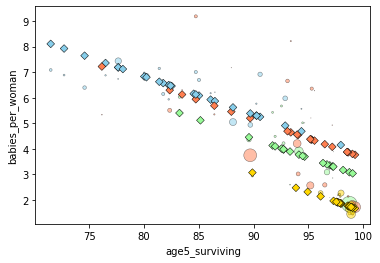

In [26]:
plotfit(surviving,training)

In [27]:
surviving.mse_resid #in sample mean squared error

1.1281422833044383

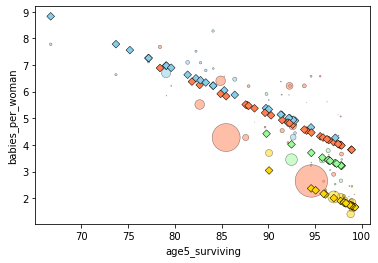

In [28]:
plotfit(surviving,testing)

To obtain the mean square there we need to do a little work. We first compute the residuals. May apply modern prediction to the testing data set. We subtract the observe data. Now we compute the number of degrees of freedom, which is the length of the data, minus the number of parameters in the model. Minus one since the number of parameters doesn't count the constant, but we should. Finally, we square up the residuals, sum them, and divide by the number of degrees of freedom.

In [16]:
resid = surviving.predict(testing) - testing.babies_per_woman
df = len(testing) - surviving.df_model - 1
np.sum(resid**2) / df

1.2343048847483307

In [17]:
def cross_validate(data,formula,response,n=100):
    ret = []
    
    for i in range(n):
        shuffled = data.sample(len(data))
        
        training, testing = shuffled.iloc[:len(data)//2], shuffled.iloc[len(data)//2:]
        
        trained = smf.ols(formula, data=training).fit()
        
        resid = trained.predict(testing) - testing[response]
        df = len(testing) - trained.df_model - 1
        mse = np.sum(resid**2) / df
        
        ret.append(mse)
    
    return np.mean(ret)

In [18]:
cross_validate(gdata,f_groupmeans,'babies_per_woman')

1.619663457106468

In [19]:
cross_validate(gdata,f_surviving,'babies_per_woman')

1.0381555740195552

In [20]:
cross_validate(gdata,f_srp,'babies_per_woman')

1.2279086009416065